In [1]:
%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt
import numpy as np

import pandas as pd
import os
import uproot
from scipy import interpolate
from scipy.optimize import curve_fit, fsolve
import json

#plt.style.use('physics.mplstyle')

In [2]:
f = uproot.open("../higgsCombineGluGluToSUEP_HT400_T2p00_mS400.000_mPhi2.000_T2.000_modegeneric.AsymptoticLimits.mH125.root")
limit = np.array(f['limit']['limit'].array())#library="np")
limit

array([], dtype=float64)

In [3]:
def get_limits(fn):
    f = uproot.open(fn)
    limit = f["limit"]['limit'].array()#library="np")
    quant = f["limit"]['quantileExpected'].array()#library="np")
    
    if limit.shape[0] == 1:
        return -1
    else:
        return np.stack([quant,limit])

def get_SUEP_file(Mass=125, temp="2p00",phi="2.00", decay="generic", path="./"):
    temp2 = temp.replace("p",".")
    temp3 = temp.split("p")[1]
    add_0 = 3- len(temp3)
    temp2 = temp2+"0"*add_0
    fname = os.path.join(
        "../higgsCombineGluGluToSUEP_HT400_T{}_mS{}.000_mPhi{}_T{}_mode{}.AsymptoticLimits.mH125.root".format(temp,Mass,phi,temp2,decay)
    )
    print (fname)
    if os.path.isfile(fname):
        return fname
    else:
        pass

In [38]:
#masses = [125,200,300,500,600,700,800,900,1000]
masses = [125,200,300,400,500,600,700,800,900,1000]
#masses = [400]
decay = "generic"
print(decay)
temp = "2p00"
phi = "2.000"
for m in masses:
    limit = get_limits(get_SUEP_file(Mass=m,temp=temp,phi=phi, decay=decay))
    print("SUEP m-"+ str(m), "\t: ", 
             np.round(limit[1,2],5), "\t+/- [",
             np.round(limit[1,3],5), ",",
             np.round(limit[1,1],5), "] :",
            np.round(limit[1,5],5)
        )

generic
../higgsCombineGluGluToSUEP_HT400_T2p00_mS125.000_mPhi2.000_T2.000_modegeneric.AsymptoticLimits.mH125.root
('SUEP m-125', '\t: ', 0.25488, '\t+/- [', 0.44182, ',', 0.16192, '] :', 0.54192)
../higgsCombineGluGluToSUEP_HT400_T2p00_mS200.000_mPhi2.000_T2.000_modegeneric.AsymptoticLimits.mH125.root
('SUEP m-200', '\t: ', 0.01904, '\t+/- [', 0.02663, ',', 0.01338, '] :', 0.02556)
../higgsCombineGluGluToSUEP_HT400_T2p00_mS300.000_mPhi2.000_T2.000_modegeneric.AsymptoticLimits.mH125.root
('SUEP m-300', '\t: ', 0.01318, '\t+/- [', 0.01865, ',', 0.00984, '] :', 0.02718)
../higgsCombineGluGluToSUEP_HT400_T2p00_mS400.000_mPhi2.000_T2.000_modegeneric.AsymptoticLimits.mH125.root
('SUEP m-400', '\t: ', 0.01611, '\t+/- [', 0.02202, ',', 0.01201, '] :', 0.03996)
../higgsCombineGluGluToSUEP_HT400_T2p00_mS500.000_mPhi2.000_T2.000_modegeneric.AsymptoticLimits.mH125.root
('SUEP m-500', '\t: ', 0.02051, '\t+/- [', 0.02803, ',', 0.01518, '] :', 0.02798)
../higgsCombineGluGluToSUEP_HT400_T2p00_mS600.0

In [39]:
#xsec = {"125": 45.2, "200": 16.9, "300":6.59, "400": 3.16, "700":0.62, "1000": 0.185}
#genfilter = {"1000":0.4929149897230587,"700":0.2816894976779231,"400":0.12259774967384872,"300":0.08115244345939307,"200":0.045499775471722015,"125":0.022561693317296093}
xsecs = {}
with open ("/uscms/home/mreid/nobackup/sueps/analysis/SUEPs/scouting/plotter/utils/xsections_2018.json") as json_file:
    xsecs = json.load(json_file)

In [40]:
def get_xsec(mass,temp1="2p00",temp2="2.000",phi="2.000",mode="generic"):
    formatting = "GluGluToSUEP_HT400_T%s_mS%s.000_mPhi%s_T%s_mode%s_TuneCP5_13TeV-pythia8"%(temp1,mass,phi,temp2,mode)
    xsec = xsecs[formatting]["xsec"]
    #print(xsec)
    return xsec

In [41]:
def log_interp1d(xx, yy, kind='linear'):
    logx = np.log(xx)
    logy = np.log(yy)
    lin_interp = interpolate.interp1d(logx, logy, bounds_error=False, fill_value="extrapolate", kind=kind)
    log_interp = lambda zz: np.power(np.e, lin_interp(np.log(zz)))
    return log_interp

In [42]:
def plot_dim_interpolate(decay="darkPho", unblind=True, quadratic=False,year="Run2",temp="2p00",phi="2.00"):
    if year == 2018:
        lumi = 60.69##59.69*1000 #lumi for 2018 scouting # A:13.978, B: 7.064, C: 6.899, D: 31.748
    elif year == 2017:
        lumi = 34.62#36.74*1000 #lumi for 2017 scouting #
    elif year == 2016:
        lumi = 30.50#35.48*1000 #lumi for 2016 scouting #
    elif year == "1718":
        lumi = 96.43 #lumi for 2018+2017 scouting #
    elif year == "Run2":
      #lumi = 96.43*1000 #lumi for 2018+2017 scouting #
        lumi = 125.81
    else:
        lumi=1
    limits = []
    limitx = []
    xsecx = []
    for Mass in masses:
    #for Mass in [400,1000]:
        try:
            limit = get_limits(get_SUEP_file(Mass=Mass,temp=temp,phi=phi, decay=decay))*get_xsec(str(Mass))
            print(limit)
            #if not isinstance(limit, int) and limit.shape == (2,6):
            limits.append(limit)#*xsec[str(Mass)]
            limitx.append(Mass)#*xsec[str(Mass)]
            xsecx.append(get_xsec(str(Mass)))#*genfilter[str(Mass)])
        except:
            print(" failed : ", Mass, " : ", decay)
            #limits.append(-1)
            #limitx.append(Mass)
            pass
    limits = np.array(limits)
    limitx = np.array(limitx)
    xsecx = np.array(xsecx)
    print(limits)
    print(limitx)
    print(xsecx)
    
    _exp = np.array([l[1][2] for l in limits]) 
    _s1p = np.array([l[1][1] for l in limits]) 
    _s1m = np.array([l[1][3] for l in limits]) 
    _s2p = np.array([l[1][0] for l in limits]) 
    _s2m = np.array([l[1][4] for l in limits])
    _obs = np.array([l[1][5] for l in limits])
    
    print(_exp)
    print(_s2p)
    print(_s2m)
    
    if quadratic:
        exp_limit = interpolate.interp1d(limitx, _exp, bounds_error=False, fill_value="extrapolate", kind="quadratic")
        s1p_limit = interpolate.interp1d(limitx, _s1p, bounds_error=False, fill_value="extrapolate", kind="quadratic")
        s1m_limit = interpolate.interp1d(limitx, _s1m, bounds_error=False, fill_value="extrapolate", kind="quadratic")
        s2p_limit = interpolate.interp1d(limitx, _s2p, bounds_error=False, fill_value="extrapolate", kind="quadratic")
        s2m_limit = interpolate.interp1d(limitx, _s2m, bounds_error=False, fill_value="extrapolate", kind="quadratic")
        obs_limit = interpolate.interp1d(limitx, _obs, bounds_error=False, fill_value="extrapolate", kind="quadratic")
    else:
        #exp_limit = interpolate.interp1d(limitx, _exp, bounds_error=False, fill_value="extrapolate", kind="linear")
        #s1p_limit = interpolate.interp1d(limitx, _s1p, bounds_error=False, fill_value="extrapolate", kind="linear")
        #s1m_limit = interpolate.interp1d(limitx, _s1m, bounds_error=False, fill_value="extrapolate", kind="linear")
        #s2p_limit = interpolate.interp1d(limitx, _s2p, bounds_error=False, fill_value="extrapolate", kind="linear")
        #s2m_limit = interpolate.interp1d(limitx, _s2m, bounds_error=False, fill_value="extrapolate", kind="linear")
        #obs_limit = interpolate.interp1d(limitx, _obs, bounds_error=False, fill_value="extrapolate", kind="linear")
        exp_limit = log_interp1d(limitx, _exp)
        s1p_limit = log_interp1d(limitx, _s1p)
        s1m_limit = log_interp1d(limitx, _s1m)
        s2p_limit = log_interp1d(limitx, _s2p)
        s2m_limit = log_interp1d(limitx, _s2m)
        obs_limit = log_interp1d(limitx, _obs)
    plt.figure(figsize=(6,6))
    ax = plt.gca()
    
    plt.plot(limitx, _exp,'.', ms=12, color='black')
    xvar = np.linspace(80,1100,1001)
    plt.plot(xvar, exp_limit(xvar), ls="--", ms=12, color='black', label="Median expected")
    
    plt.fill_between(xvar, s2m_limit(xvar), s2p_limit(xvar), color="#FFCC01", lw=0, label="Expected 95%")
    plt.fill_between(xvar, s1m_limit(xvar), s1p_limit(xvar), color="#00CC00", lw=0, label="Expected 68%")

    #Observed limit
    plt.plot(limitx, _obs,'.', ms=12, color='black')
    plt.plot(xvar, obs_limit(xvar), ls="-", ms=12, color='black', label="Median Observed")
    
    #Theoretical cross section
    plt.plot(limitx,xsecx,
    #plt.plot(masses,xsecx,
    #plt.plot(masses,list(xsec.values()), #*.101,#* 0.101* 2/3, 
             "--", ms=12, color='blue', label="$\sigma_{theory}$ (pb)")
    plt.ylim([0.0, 200])
    plt.xlim([80, 1100 ])
    
    #plt.ylabel(r"$\sigma(SUEP)$ (fb)")
    #plt.ylabel(r"$\mu(\frac{\sigma_{obs}}{\sigma_{theo}})$")
    plt.ylabel(r"$\sigma_{obs}$ (pb)")
    plt.xlabel(r"$M_{SUEP}$ (GeV)")
    plt.legend(loc="upper left", fontsize=14)
    cms = plt.text(
        0., 1., u"CMS $\it{preliminary}$",
        fontsize=16, fontweight='bold',
        horizontalalignment='left', 
        verticalalignment='bottom', 
        transform=ax.transAxes
    )
    lumi = plt.text(
        1., 1., r"%.1f fb$^{-1}$ (13 TeV)" % lumi,
        fontsize=14, horizontalalignment='right', 
        verticalalignment='bottom', 
        transform=ax.transAxes
    )
    info = plt.text(
        0.6, 0.8, r"Temp = %.1f GeV""\n""$M_{d}$ = %.1f GeV""\n""generic"%(float(temp.replace("p",".")),float(phi)),
        fontsize=14, horizontalalignment='left', 
        verticalalignment='bottom', 
        transform=ax.transAxes
    )
    plt.grid(b=True, which='major', color='grey', linestyle='--', alpha=0.3)
    plt.ylim(1e-4,9e5)
    plt.yscale("log")
    plt.savefig("../../../../../scouting/plotter/Plots/SUEP_limits_d_{}_{}_{}_{}.pdf".format(decay,year,temp,phi))
    plt.savefig("../../../../../scouting/plotter/Plots/SUEP_limits_d_{}_{}_{}_{}.png".format(decay,year,temp,phi))

    plt.show()

('decay : ', 'generic')
../higgsCombineGluGluToSUEP_HT400_T2p00_mS125.000_mPhi2.000_T2.000_modegeneric.AsymptoticLimits.mH125.root
[[  1.13000002   7.23199984  22.6         37.96799881  44.07000108
  -45.2       ]
 [  5.53688965   7.94744625  12.7125      22.34028857  38.52938275
   20.47200767]]
../higgsCombineGluGluToSUEP_HT400_T2p00_mS200.000_mPhi2.000_T2.000_modegeneric.AsymptoticLimits.mH125.root
[[  0.42250001   2.70399994   8.45        14.19599956  16.4775004
  -16.9       ]
 [  0.10959625   0.15190363   0.20629883   0.31813381   0.45823589
    0.10663624]]
../higgsCombineGluGluToSUEP_HT400_T2p00_mS300.000_mPhi2.000_T2.000_modegeneric.AsymptoticLimits.mH125.root
[[ 0.16475     1.05439998  3.295       5.53559983  6.42525016 -6.59      ]
 [ 0.02714996  0.0350687   0.0482666   0.06365802  0.08703374  1.54569154]]
../higgsCombineGluGluToSUEP_HT400_T2p00_mS400.000_mPhi2.000_T2.000_modegeneric.AsymptoticLimits.mH125.root
[[ 0.079       0.50559999  1.58        2.65439992  3.08100008 -3

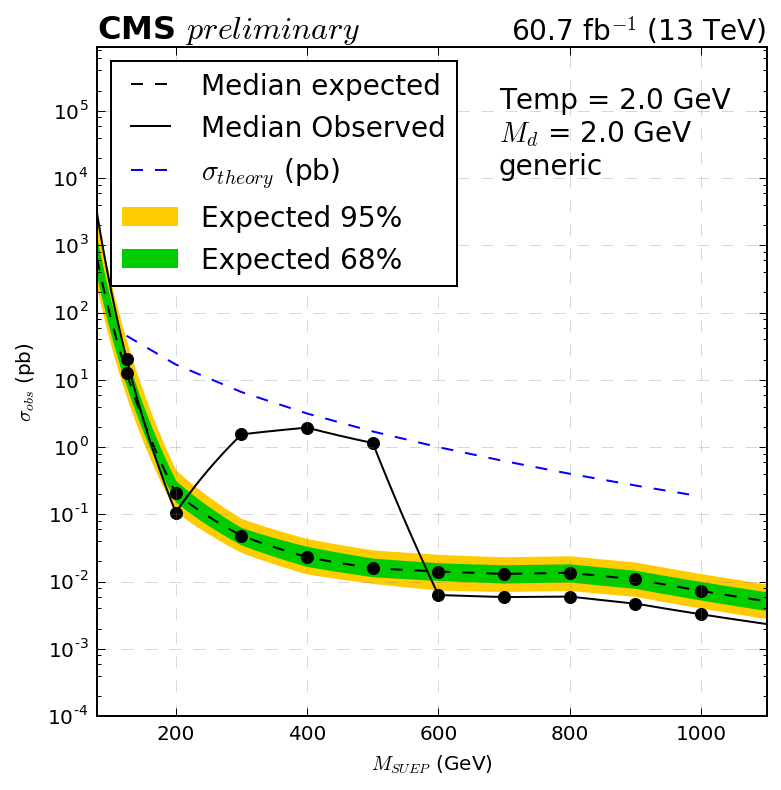

In [44]:
year=2018
#year="Run2"
#year="1718"
#temp = "6p00"
#phi = "3.000"
#temp = "0p50"
temp = "2p00"
phi = "2.000"
for decay in ["generic"]:
    print("decay : ", decay)
    plot_dim_interpolate(decay=decay, unblind=False, quadratic=False,year=year,temp=temp,phi=phi)